In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

## Data Processing and Transformation

### Data Source
We were able to secure historical data from health insurance companies that provides information tracked by the insurance company to track payments for services rendered to patients, medication prescriptions, and other relevant information pertaining to patients and the insurance company. This data is all cleansed and staged with the purpose of building out predictive modeling to support population health initiatives and improving patient care.

Example data elements include the following:

**Patient Demographic Data**

This is data collected on members of the insurance company when you enroll with a plan
- age
- race 
- gender
- language
    
**Enrollment Data**

Historical information of what members were enrolled on the plan when tracks the enrollment segments of members on specific plan with their specific benefit packages
- duration on plan type
- insurance type
- duration with primary care provider
- eR visits
- inpatient admissions
- readmissions
- PCP visits

**Patient Medications**

Historical prescription fills for each members
- NDC (medication type)
- dosage
- supply
- recent prescription fill count
- drug type
- patient diseases

**Disease/Condition list for each member**

Examples:
- Asthma Indicator
- Diabetes Indicator

### Data Processing

In order to perform analysis and modeling on our dataset, our goal was to flatten all of the above data sources into a patient record. The reason behind this is so that we have a representation of the current and past state of each patient contained within one record. In order to do this, we created a record with features representing the different aspects of each patient we want to model on, and ran aggregation across the different data sources to fill in the features for each patient.

**Demographic Data**

This data was already in the form of one line per patient so no transformation was needed

**Event Data**

This data source was structured as a one line per visit dataset, meaning that a single patient may have multiple lines containing data relevant to our analysisn. This data was collapsed down into indicator features which were one hot encoded. This included features such as ER visits within the last 12, 6, 3, and 1 months. We performed similar tranformation on PCP visits and inpatient admissions.

**Patient Medication Data**

This data source was structured on a one line per medication per fill basis. This means that each patient would have a record for every time they fill a medication, for each medication that they are currently perscribed. This data was collapsed down into indicators features and into count features. The count features represented how many times a patient had filled any perscription within the past 6 and 12 months. The indicator features represent one hot features indicating the class of medication that a patient might have filled, such as "high risk", "opioid", and "potentially harmful".

**Disease Data**

This data source was structured on a per disease per patient basis. This data was collapsed down into a high number of one hot features indicating whether or not a patient had been diagnosed with a given disease. For the majority of patients this resulted in a sparse data set with only one or two features that were relevent to them.

In [22]:
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5433'
POSTGRES_USERNAME = 'nick'
POSTGRES_PASSWORD = '00tracker'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
   username=POSTGRES_USERNAME, 
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname='project'))
# Create the connection
cnx = sqlalchemy.create_engine(postgres_str)

In [54]:
raw_data = pd.read_sql_query('select * from patient_record order by random() limit 20000', cnx)
raw_data.fillna(0, inplace=True)
raw_data.drop(columns=["as_of_date", "patient_id", 
                       "patient_race", "patient_language", 
                       "patient_gender"], inplace=True)

In [55]:
non_temporal_features = [
    "prev_admission_12mo",
    "prev_er_12mo",
    "prev_pcp_12mo"
]

temporal_features = [ 
    "prev_admission_6mo",
    "prev_admission_3mo",
    "prev_admission_1mo",
    "prev_er_6mo",
    "prev_er_3mo",
    "prev_er_1mo",
    "prev_pcp_6mo",
    "prev_pcp_3mo",
    "prev_pcp_1mo"
]
time_based_features = non_temporal_features + temporal_features

train_data, test_data = train_test_split(raw_data, test_size=0.2)

# Drop columns with all same values
column_sums = train_data.sum(0)
dropped_columns = []
for i in range(len(column_sums)):
    if column_sums[i] == 0:
        dropped_columns.append(train_data.columns[i])
train_data = train_data.drop(columns=dropped_columns)
test_data = test_data.drop(columns=dropped_columns)

# standardize data
data_mean = train_data.mean()
data_std = train_data.std()
train_data_norm = (train_data - data_mean) / data_std
test_data_norm = (test_data - data_mean) / data_std

# Labels
train_lab_12mo = train_data["fut_admission_12mo"].values
train_lab_6mo = train_data["fut_admission_6mo"].values
train_lab_3mo = train_data["fut_admission_3mo"].values
train_lab_1mo = train_data["fut_admission_1mo"].values
test_lab_12mo = test_data["fut_admission_12mo"].values
test_lab_6mo = test_data["fut_admission_6mo"].values
test_lab_3mo = test_data["fut_admission_3mo"].values
test_lab_1mo = test_data["fut_admission_1mo"].values

# Feature Data
train_features = train_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])
test_features = test_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])

no_temp_train_features = train_features.drop(columns=temporal_features)
no_temp_test_features = test_features.drop(columns=temporal_features)
temp_train_features = train_features
temp_test_features = test_features

models = [
    ("Non-Temporal Model", no_temp_train_features, no_temp_test_features),
    ("Temporal Model", temp_train_features, temp_test_features)
]

labels = [
    ("12 Month Readmission", train_lab_12mo, test_lab_12mo),
    ("6 Month Readmission", train_lab_6mo, test_lab_6mo),
    ("3 Month Readmission", train_lab_3mo, test_lab_3mo),
    ("1 Month Readmission", train_lab_1mo, test_lab_1mo)
]
names = [x[0] for x in labels]

In [53]:
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

for model_name, train_feats, test_feats in models:
    print(name)
    model_scores = []
    for name, train_lab, test_lab in labels:
        print(model_name)
        model = ExtraTreesClassifier(n_estimators=50)
        model.fit(train_feats, train_lab)
        feat_scores = []
        for i in range(len(model.feature_importances_)):
            feat_scores.append((train_feats.columns[i], model.feature_importances_[i]))
        feat_scores = sorted(feat_scores, key=lambda x: -x[1])
        score_total = 0
        for feature, score in feat_scores:
            if feature in time_based_features:
                score_total += score
        model_scores.append(score_total)
    
    ax.bar(x - width/2, no_temp_scores, width, label='Non-Temporal')
    ax.bar(x + width/2, temp_scores, width, label='Temporal')

    ax.set_ylabel('Accuracy Score')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    fig.tight_layout()
    plt.xticks(rotation=45)
    plt.ylim((.8, 1))
    plt.show()

12 Month Readmission
Non-Temporal Model
prev_admission_12mo: 0.04298762276340539
prev_er_12mo: 0.03423611149121229
prev_pcp_12mo: 0.02746038043489344
Temporal Model
prev_er_12mo: 0.02593907116932029
prev_admission_12mo: 0.023623417926103528
prev_pcp_1mo: 0.016804888088770512
prev_pcp_3mo: 0.016113897525501363
prev_er_6mo: 0.015003049178265204
prev_pcp_12mo: 0.0149160695891953
prev_admission_6mo: 0.013903878806830037
prev_pcp_6mo: 0.01341335605685917
prev_er_3mo: 0.012227059289001656
prev_admission_3mo: 0.010702754304363151
prev_er_1mo: 0.00635531056411123
prev_admission_1mo: 0.004436091236666238
6 Month Readmission
Non-Temporal Model


KeyboardInterrupt: 

## Comparison of Temporal and Non-Temporal Models

To isolate the effects of adding a temporal factor to our models, we first built models ignoring the features without temporal component on them and focused in on the previous admission features. We created two basic models:

- One model with just the feature "prev_admission", the "non-temporal model
- One model with the same feature broken out into 4 features, prev_admission within 12, 6, 3, and 1 month, the "temporal model"

We created both of these models using a logistic classifier and compared them agains eachother over a range of decision thresholds, using the highest accuracy from each model on a number of response variables, The results are below:

[[36886   344]
 [ 2515   255]]
[[38235   137]
 [ 1556    72]]
[[39060    61]
 [  870     9]]
[[39654     7]
 [  338     1]]


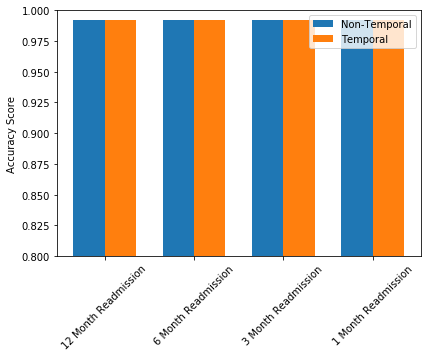

In [52]:
# Compare the two models against eachother

no_temp_scores = []
temp_scores = []
for period, train_lab_Xmo, test_lab_Xmo in labels:

    no_temp_model = RandomForestClassifier().fit(no_temp_train_features, train_lab_Xmo)
    temp_model = RandomForestClassifier().fit(temp_train_features, train_lab_Xmo)

    no_temp_preds = no_temp_model.predict(no_temp_test_features)
    no_temp_score = accuracy_score(test_lab_Xmo, no_temp_preds)

    temp_preds = temp_model.predict(temp_test_features)
    temp_score = accuracy_score(test_lab_Xmo, temp_preds)
    print(confusion_matrix(test_lab_Xmo, temp_preds))
        
    max_no_temp_score = max(max_no_temp_score, no_temp_score)
    max_temp_score = max(max_temp_score, temp_score)
        
    no_temp_scores.append(max_no_temp_score),
    temp_scores.append(max_temp_score)

x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_temp_scores, width, label='Non-Temporal')
rects2 = ax.bar(x + width/2, temp_scores, width, label='Temporal')

ax.set_ylabel('Accuracy Score')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
fig.tight_layout()
plt.xticks(rotation=45)
plt.ylim((.8, 1))
plt.show()
        